# AI6126 ACV P1 - Inference Notebook

In [ ]:
nb_ver = 0.3
title = f'ai6126-p1-inference-v{nb_ver}'
print(title)

## Versioning and References

### Changelogs
+ V0.1 - Added inference codes
+ V0.2 - Added analysis
+ V0.3 - Added prediction

### References
+ None

## Load Inference Model

### Imports

In [2]:
import sys, os
import shutil
import time
import random
import numpy as np
import copy
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import json
from pprint import pprint

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import config
from celeba_dataset import CelebaDataset, CelebaTestset
import models
from utils import Logger, ModelTimer, AverageMeter, accuracy, print_attribute_acc

import seaborn as sns
sns.set()

# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

In [3]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # force cpu
print(device)

ISJUPYTER = False
if 'ipykernel' in sys.modules:
    ISJUPYTER = True
    # set the backend of matplotlib to the 'inline' backend
    %matplotlib inline
    config.disable_tqdm = False
    
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [4]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)#config.manual_seed

### Data Transform

In [5]:
IMAGE_H = 198 #158 218 148 198
IMAGE_W = 158 #178 148 158

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
def load_dataloaders(print_info=True, albu_transforms = True, img_h=218, img_w=158):
    phases = ['val', 'test'] #'train'

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.CenterCrop((img_h, img_w)), #new
                transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                #transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                #transforms.Resize(178), #new
                transforms.CenterCrop((img_h, img_w)),
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                #transforms.Resize(178), #new
                transforms.CenterCrop((img_h, img_w)),
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                A.CenterCrop(height=img_h, width=img_w),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                 rotate_limit=15, p=0.5), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                A.HorizontalFlip(p=0.5),
                #A.HueSaturationValue(hue_shift_limit=14, sat_shift_limit=14, val_shift_limit=14, p=0.5),
                #A.FancyPCA(alpha=0.1, p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                A.RandomBrightnessContrast(p=0.5),
                A.GaussNoise(var_limit=10.0, p=0.5), 
                #A.GaussianBlur(p=0.1), # AFFACT https://arxiv.org/pdf/1611.06158.pdf
                #A.CoarseDropout(max_holes=1, max_height=74, max_width=74, 
                #               min_height=49, min_width=49, fill_value=0, p=0.2), #https://arxiv.org/pdf/1708.04896.pdf
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                #Rescale an image so that minimum side is equal to max_size 178 (shortest edge of Celeba)
                #A.SmallestMaxSize(max_size=178), 
                A.CenterCrop(height=img_h, width=img_w),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                #A.SmallestMaxSize(max_size=178),
                A.CenterCrop(height=img_h, width=img_w),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x], albu=albu_transforms) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    class_names = image_datasets['test'].targets
    
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names



In [7]:
dataloaders, attribute_names = load_dataloaders(albu_transforms = True, img_h=IMAGE_H, img_w=IMAGE_W)

Dataset sizes: {'val': 19867, 'test': 19962}
Class Labels: 40


In [8]:
def load_testset(print_info=True, albu_transforms = False, img_h=218, img_w=158):    
    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                   'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                   'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                   'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                   'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                   'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                   'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        
        test_transforms = transforms.Compose([
            transforms.Resize((218, 218)), 
            transforms.CenterCrop((img_h, img_w)),
            transforms.ToTensor(),
            normalize
        ])
        
    if albu_transforms:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                              std=(0.229, 0.224, 0.225))
        
        test_transforms = A.Compose([
            #A.SmallestMaxSize(max_size=178),
            A.Resize(height=218, width=218),
            A.CenterCrop(height=img_h, width=img_w),
            normalize_A,
            ToTensorV2(),
        ]) 
        
    test_dataset = CelebaTestset(config.TESTSET_DIR, transform=test_transforms)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.test_batch, 
                                             pin_memory=True, shuffle=False, num_workers=config.dl_workers)
    if print_info:
        print(f"Testset size: {len(test_dataset)}")
        print(f"Number of Celebs: {len(test_dataset.celeba_ctr.keys())}")
        
    return test_dataset, test_loader, attribute_names

In [9]:
test_dataset, test_loader, attribute_names = load_testset(albu_transforms = True, img_h=IMAGE_H, img_w=IMAGE_W)

Testset size: 13233
Number of Celebs: 5749


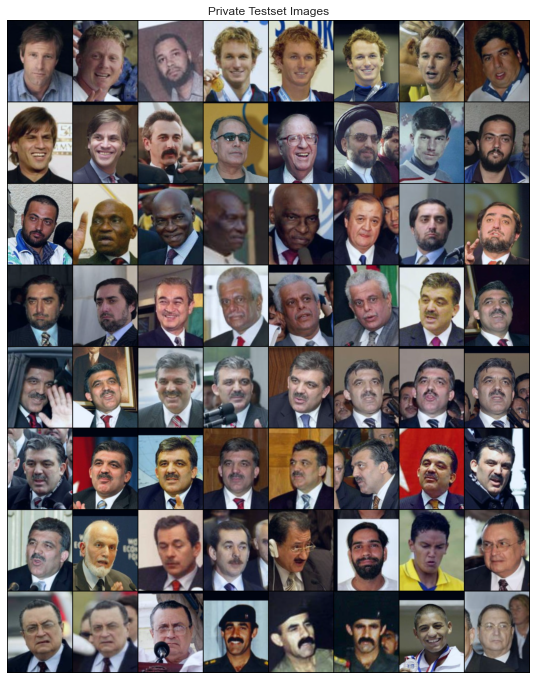

In [10]:
if True:
    real_batch = next(iter(test_loader))
    plt.figure(figsize=(12,12))
    plt.axis("off")
    plt.title("Private Testset Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Model Architecture Initialization

In [11]:
def create_model(arch, layers, device):
    print("=> creating model '{}'".format(arch))
    if arch.startswith('FaceAttrResNet'):
        model = models.__dict__[arch](resnet_layers = layers)
    elif arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[arch](resnet_layers = layers)
    elif arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[arch]()
    model = model.to(device)
    return model

In [12]:
def format_checkpoint(modelname, opt_name, bias_decay=False, ckp_resume=None):
    best_prec1 = 0

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        checkpoint = torch.load(ckp_resume)
        print(checkpoint['arch'])
        try:
            total_time = checkpoint['total_time']
        except:
            total_time = 0
        try:
            lr = checkpoint['lr']
        except:
            lr = 0.1
        is_best=False
        state = {
            'epoch': checkpoint['epoch'],
            'arch': modelname,
            'state_dict': checkpoint['state_dict'],
            'best_prec1': checkpoint['best_prec1'],
            'opt_name': opt_name,
            'optimizer' : checkpoint['optimizer'],
            'lr': lr,
            'total_time': total_time,
            'bias_decay': bias_decay
        }
        torch.save(state, ckp_resume)
        
    else:
        raise

In [13]:
#format_checkpoint('FaceAttrResNeXt_50', 'SGD', False, ckp_resume="inf\\FaceAttrResNeXt50_42_s58e60_tb100_vb100_CE_SGD_next_step_lr0.1_wd0.0001_g0.1_sp30_M\\20201005_165042\\model_best.pth.tar")

In [14]:
def load_inference_model(device, ckp_resume):
    if not (ckp_resume and os.path.isfile(ckp_resume)):
        print("[W] Checkpoint not found for inference.")
        raise 
    
    print(f"=> loading checkpoint: {ckp_resume}")
    checkpoint = torch.load(ckp_resume)
    try:
        total_time = checkpoint['total_time']
        model_timer = ModelTimer(total_time)
        print(f"=> model trained time: {model_timer}")
    except:
        print(f"=> old model")
    best_prec1 = checkpoint['best_prec1']
    print(f"=> model best val: {best_prec1}")

    print(f"=> resuming model: {checkpoint['arch']}")
    model = create_model(checkpoint['arch'].split('_')[0], 
                         int(checkpoint['arch'].split('_')[1]), 
                         device)
    model.load_state_dict(checkpoint['state_dict'])
              
    return best_prec1, model


In [15]:
config.INFERENCE_DIR = 'inf'
lfile = 'model_best.pth.tar'
inf_models = {}
ctr = 0
for dirt in os.listdir(config.INFERENCE_DIR):
    dirpath = os.path.join(config.INFERENCE_DIR, dirt)
    for run in os.listdir(dirpath):
        runpath = os.path.join(dirpath, run)
        if os.path.isdir(runpath): 
            for filename in os.listdir(runpath):
                if filename == lfile:
                    best_prec1, model = load_inference_model(device, os.path.join(runpath,lfile))
                    del model
                    inf_models[ctr] = (os.path.join(runpath,lfile), dirt, run, best_prec1)
                    ctr += 1
                
print(f'==> {len(inf_models)} inference model(s) found.')

=> loading checkpoint: inf\FaceAttrMobileNetV2_50_42_s0e80_tb100_vb100_MU_FL_SGD_53_lr0.01_wd0.0001_ReduceLROnPlateau\20201020_011817\model_best.pth.tar
=> model trained time: 04:55:13
=> model best val: 92.28230230052333
=> resuming model: FaceAttrMobileNetV2_50
=> creating model 'FaceAttrMobileNetV2'
=> loading checkpoint: inf\FaceAttrResNeXt_50_42_s0e80_tb128_vb128_MU_FL_SGD_52_lr0.01_wd0.0001_ReduceLROnPlateau\20201020_100816\model_best.pth.tar
=> model trained time: 04:33:30
=> model best val: 92.09618965966321
=> resuming model: FaceAttrResNeXt_50
=> creating model 'FaceAttrResNeXt'
==> 2 inference model(s) found.


In [16]:
keydict = {mid: (name, acc) for mid, (_, name, _, acc) in inf_models.items()}
pprint(f'{keydict}')

('{0: '
 "('FaceAttrMobileNetV2_50_42_s0e80_tb100_vb100_MU_FL_SGD_53_lr0.01_wd0.0001_ReduceLROnPlateau', "
 '92.28230230052333), 1: '
 "('FaceAttrResNeXt_50_42_s0e80_tb128_vb128_MU_FL_SGD_52_lr0.01_wd0.0001_ReduceLROnPlateau', "
 '92.09618965966321)}')


In [17]:
SAVE_FILES = True
selected_model = int(input("Enter model index: "))
p_run = inf_models[selected_model][2]
p_model_name = inf_models[selected_model][1]
run_dir = os.path.join(config.INFERENCE_DIR, p_model_name)
p_model_acc, p_model = load_inference_model(device, inf_models[selected_model][0]) 
#print(f"=> best model val: {p_model_acc}")

Enter model index:  0


=> loading checkpoint: inf\FaceAttrMobileNetV2_50_42_s0e80_tb100_vb100_MU_FL_SGD_53_lr0.01_wd0.0001_ReduceLROnPlateau\20201020_011817\model_best.pth.tar
=> model trained time: 04:55:13
=> model best val: 92.28230230052333
=> resuming model: FaceAttrMobileNetV2_50
=> creating model 'FaceAttrMobileNetV2'


## Accuracy

In [18]:
def validate(val_loader, model):
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader)):
            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            
            # compute output
            output = model(X)
            # measure accuracy
            prec1 = []
            for j in range(len(output)):
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                top1[j].update(prec1[j][0].item(), X.size(0))

            top1_avg = [top1[k].avg for k in range(len(top1))]
            prec1_avg = sum(top1_avg) / len(top1_avg)
        
    return (prec1_avg, top1)

In [19]:
val_prec1, val_top1 = validate(dataloaders['val'], p_model)
print(f"=> Best val accuracy: {val_prec1}")
v_attr_acc = print_attribute_acc(val_top1, attribute_names)

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.34it/s]

=> Best val accuracy: 92.28230230052333
5_o_Clock_Shadow: 94.68968639929653
Arched_Eyebrows: 86.66633109299461
Attractive: 82.02043589258216
Bags_Under_Eyes: 85.25192528291348
Bald: 99.1241757650227
Bangs: 96.14939345503187
Big_Lips: 85.27709265355766
Big_Nose: 83.63618059216408
Black_Hair: 92.12261537699825
Blond_Hair: 96.03865705415132
Blurry: 96.81884531370676
Brown_Hair: 86.3441888432189
Bushy_Eyebrows: 93.07394170086667
Chubby: 95.87758593502382
Double_Chin: 96.96984949532924
Eyeglasses: 99.60235566133316
Goatee: 96.9446821285253
Gray_Hair: 98.17284944883475
Heavy_Makeup: 92.98837266294983
High_Cheekbones: 88.99179543468152
Male: 98.90270297094207
Mouth_Slightly_Open: 94.27694164285148
Mustache: 96.45140180291591
Narrow_Eyes: 93.92459856904003
No_Beard: 96.52690390332774
Oval_Face: 76.60945285538479
Pale_Skin: 97.01011727223094
Pointy_Nose: 77.9886243534765
Receding_Hairline: 94.90109224435145
Rosy_Cheeks: 95.22826797056014
Sideburns: 97.54869884733478
Smiling: 93.55715506976988
S

In [20]:
test_prec1, test_top1 = validate(dataloaders['test'], p_model)
print(f"=> Best test accuracy: {test_prec1}")
test_attr_acc = print_attribute_acc(test_top1, attribute_names)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.90it/s]

=> Best test accuracy: 91.71250375855269
5_o_Clock_Shadow: 94.92535818895134
Arched_Eyebrows: 84.26510369855313
Attractive: 83.37340946807112
Bags_Under_Eyes: 85.74291152273793
Bald: 99.03817252780283
Bangs: 96.33804228874094
Big_Lips: 71.50586114762457
Big_Nose: 84.78609356862512
Black_Hair: 90.36168721180594
Blond_Hair: 96.1677186738727
Blurry: 96.52339444716078
Brown_Hair: 89.75052599251933
Bushy_Eyebrows: 92.99168420838828
Chubby: 95.93227130861992
Double_Chin: 96.52840396524515
Eyeglasses: 99.6844003606853
Goatee: 97.53030757982403
Gray_Hair: 98.25167819696657
Heavy_Makeup: 92.03486623898762
High_Cheekbones: 88.07734696304448
Male: 98.60735397025466
Mouth_Slightly_Open: 94.08876865586852
Mustache: 97.05440337709764
Narrow_Eyes: 87.84189961919468
No_Beard: 96.49333733865463
Oval_Face: 76.84099789905997
Pale_Skin: 97.2748221728095
Pointy_Nose: 77.82787296855848
Receding_Hairline: 94.04869252189512
Rosy_Cheeks: 95.31109108144709
Sideburns: 97.96613565545655
Smiling: 93.31730287087703

In [21]:
if SAVE_FILES:
    json_save_dir = os.path.join(run_dir, p_run)
    vpfile = os.path.join(json_save_dir, "val_preds.json")
    json.dump(v_attr_acc, open(vpfile,'w'))
    tpfile = os.path.join(json_save_dir, "test_preds.json")
    json.dump(test_attr_acc, open(tpfile,'w'))

In [22]:
del dataloaders

## Make Predictions

In [23]:
maxk = 1
preds = pd.DataFrame(index=test_dataset.imagenames, columns=attribute_names)
preds.index.name = "Images"
p_model.eval()

for X, names in tqdm(test_loader, disable=False):
    inputs = X.to(device, non_blocking=True)

    top_k_preds = []
    with torch.no_grad():
        outputs = p_model(inputs) # 40, BS
    
        for attr_scores in outputs:
            _, attr_preds = attr_scores.topk(maxk, 1, True, True)
            top_k_preds.append(attr_preds.t())
            
    all_preds = torch.cat(top_k_preds, dim=0) 

    all_preds = all_preds.permute(1,0).cpu()
    all_preds[all_preds == 0] = -1
    for j in range(len(names)):
        preds.loc[names[j], :] = all_preds[j]
preds

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:18<00:00,  7.21it/s]


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
Images,,,,,,,,,,,,,,,,,,,,,
Aaron_Eckhart_0001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
Aaron_Guiel_0001.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
Aaron_Patterson_0001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Aaron_Peirsol_0001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,1,-1,-1,-1,-1,-1,1
Aaron_Peirsol_0002.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zorica_Radovic_0001.jpg,-1,-1,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Zulfiqar_Ahmed_0001.jpg,-1,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
Zumrati_Juma_0001.jpg,-1,-1,-1,-1,-1,-1,1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,1


In [24]:
if SAVE_FILES:
    pfile = os.path.join(run_dir, "predictions.csv")
    ptxtfile = os.path.join(run_dir, "predictions.txt")
    preds.to_csv(ptxtfile, sep=' ', header=False)
    preds.to_csv(pfile, index=True)

### Analyze Predictions

Index([], dtype='object', name='Images')
Index([], dtype='object', name='Images')
Index([], dtype='object', name='Images')
Index(['Bill_Parcells_0002.jpg', 'Chris_Matthews_0001.jpg',
       'Doris_Roberts_0003.jpg', 'Elizabeth_Taylor_0001.jpg',
       'Jane_Rooney_0001.jpg', 'Judi_Dench_0002.jpg',
       'Sally_Kirkland_0003.jpg', 'Sally_Kirkland_0004.jpg',
       'Tippi_Hedren_0001.jpg'],
      dtype='object', name='Images')
Index([], dtype='object', name='Images')


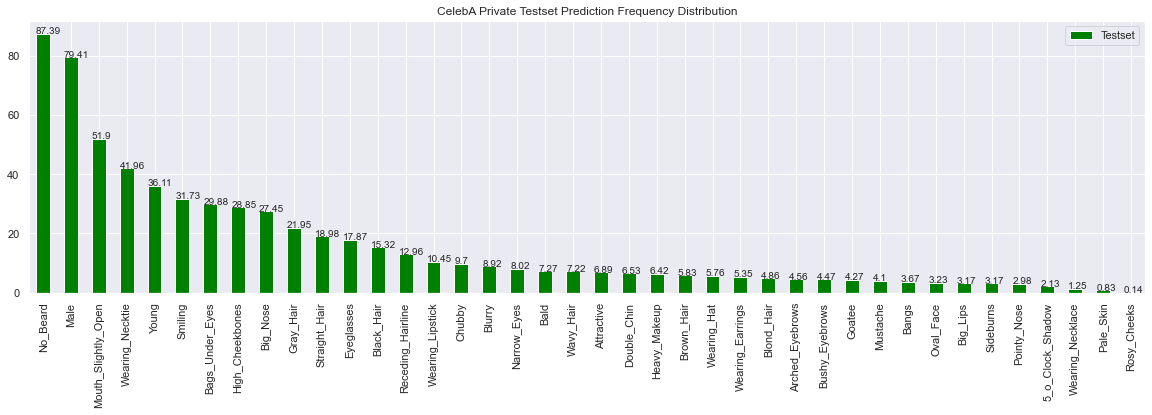

In [25]:
stat_df = pd.DataFrame(index = attribute_names)
stat_df.loc[:,'Testset'] = (preds.iloc[:,:] == 1).mean(axis=0)*100
stat_df = stat_df.sort_values('Testset', ascending=False)
fig, ax = plt.subplots()
stat_df.plot(title='CelebA Private Testset Prediction Frequency Distribution', 
             kind='bar', figsize=(20, 5), ax=ax, color='green')
for p in ax.patches:
    value = round(p.get_height(),2)
    ax.annotate(str(value), xy=(p.get_x(), p.get_height()))
plt.savefig('private_test.png',dpi=160, bbox_inches='tight')
print(preds[(preds['Young']==1) & (preds['Gray_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Mustache']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Goatee']==1)].index)
print(preds[(preds['Gray_Hair']==1) & (preds['Blond_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['No_Beard']==-1)].index)

In [26]:
print(preds[(preds['Rosy_Cheeks']==1) & (preds['Rosy_Cheeks']==1)].index)
print(len(preds[(preds['Rosy_Cheeks']==1) & (preds['Rosy_Cheeks']==1)].index))
print(preds[(preds['Wearing_Necklace']==1) & (preds['Wearing_Necklace']==1)].index)
print(len(preds[(preds['Wearing_Necklace']==1) & (preds['Wearing_Necklace']==1)].index))

Index(['Britney_Spears_0001.jpg', 'Britney_Spears_0002.jpg',
       'Britney_Spears_0003.jpg', 'Britney_Spears_0004.jpg',
       'Britney_Spears_0005.jpg', 'Britney_Spears_0014.jpg',
       'Daisy_Fuentes_0003.jpg', 'Elizabeth_Taylor_0001.jpg',
       'Hillary_Clinton_0004.jpg', 'Jennifer_Lopez_0003.jpg',
       'Jennifer_Lopez_0016.jpg', 'Kristin_Davis_0002.jpg',
       'Natalie_Imbruglia_0001.jpg', 'Nia_Vardalos_0002.jpg',
       'Nia_Vardalos_0005.jpg', 'Renee_Zellweger_0003.jpg',
       'Rita_Moreno_0002.jpg', 'Svetlana_Koroleva_0001.jpg'],
      dtype='object', name='Images')
18
Index(['Alexa_Loren_0001.jpg', 'Alicia_Keys_0001.jpg',
       'Angela_Lansbury_0001.jpg', 'Aretha_Franklin_0001.jpg',
       'Beatriz_Merino_0001.jpg', 'Britney_Spears_0004.jpg',
       'Britney_Spears_0006.jpg', 'Britney_Spears_0014.jpg',
       'Brooke_Gordon_0001.jpg', 'Carla_Tricoli_0001.jpg',
       ...
       'Tippi_Hedren_0001.jpg', 'Tippi_Hedren_0002.jpg',
       'Toni_Braxton_0002.jpg', 'Toni_Brax

In [27]:
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def get_celeb_prediction(preds, name, first_img=True):
    celeb_preds = preds[preds.index.str.contains(name)]
    celeb_first = celeb_preds.index[0]
    celeb_stat = pd.DataFrame(index = attribute_names)
    celeb_stat.loc[:,name] = (celeb_preds.iloc[:,:] == 1).mean(axis=0)*100
    mycolor = 'skyblue' if celeb_stat.loc['Male',name] >= 50 else 'magenta'
    celeb_stat = celeb_stat.sort_values(name, ascending=False)
    ncols = 3 if first_img else 2
    ax = plt.subplot2grid((1, ncols), (0, 0), colspan=2)
    celeb_stat.plot(title=name+' Prediction Frequency Distribution', 
                 kind='bar', figsize=(20, 5), color=mycolor, ax=ax)
    for p in ax.patches:
        value = round(p.get_height(),2)
        ax.annotate(str(value), xy=(p.get_x(), p.get_height()))
    if first_img:
        ax2 = plt.subplot2grid((1, ncols), (0, 2), colspan=1)
        index = test_dataset.imagenames.index(celeb_first)    
        s_img = inv_normalize(test_dataset[index][0]).permute(1, 2, 0)
        ax2.imshow(s_img)
        ax2.set_axis_off()
        plt.title(celeb_first)
        plt.tight_layout()
    plt.show()

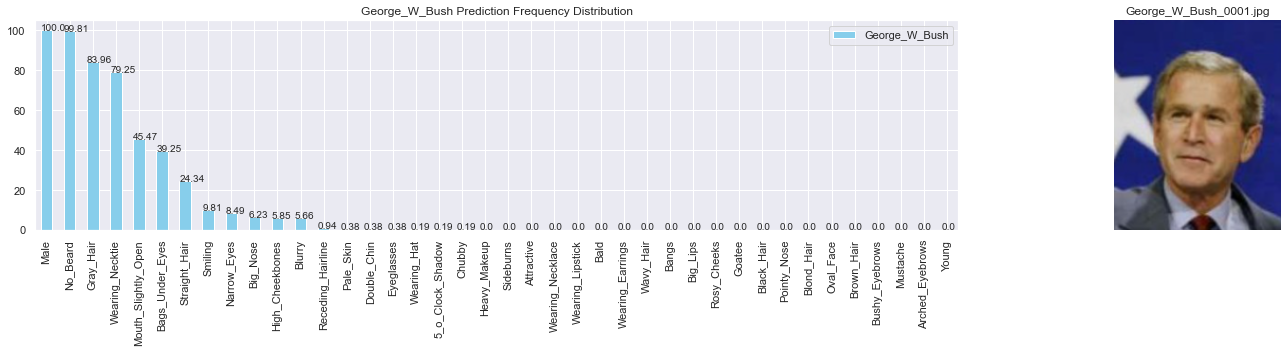

In [28]:
get_celeb_prediction(preds, name = 'George_W_Bush', first_img=True) # Male, Gray_Hair, Blonde, Necktie

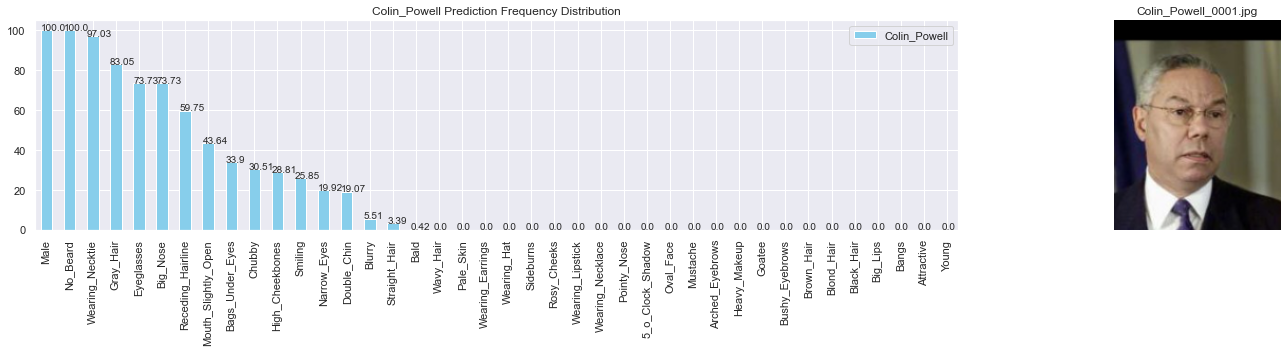

In [29]:
get_celeb_prediction(preds, name = 'Colin_Powell', first_img=True)  # Male, Gray_Hair, Necktie

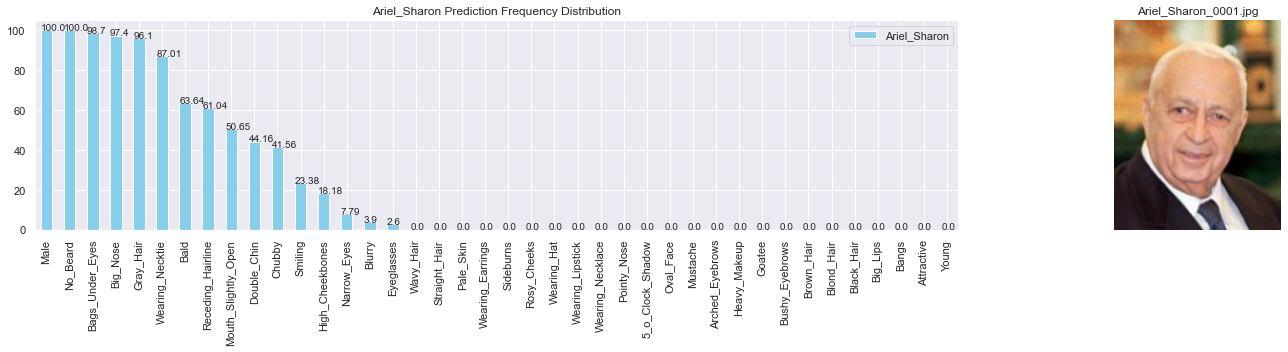

In [30]:
get_celeb_prediction(preds, name = 'Ariel_Sharon', first_img=True) # Male, Gray_Hair, Necktie

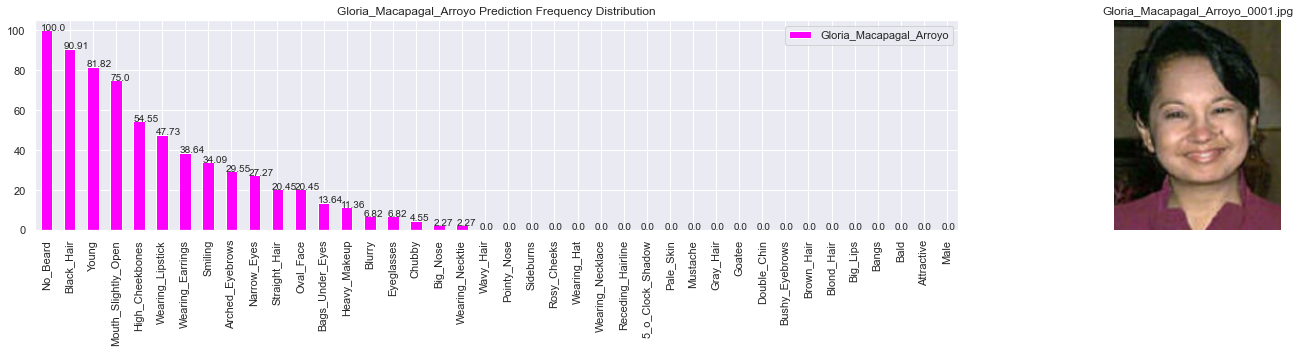

In [31]:
get_celeb_prediction(preds, name = 'Gloria_Macapagal_Arroyo', first_img=True)  # Female, Not Young!!

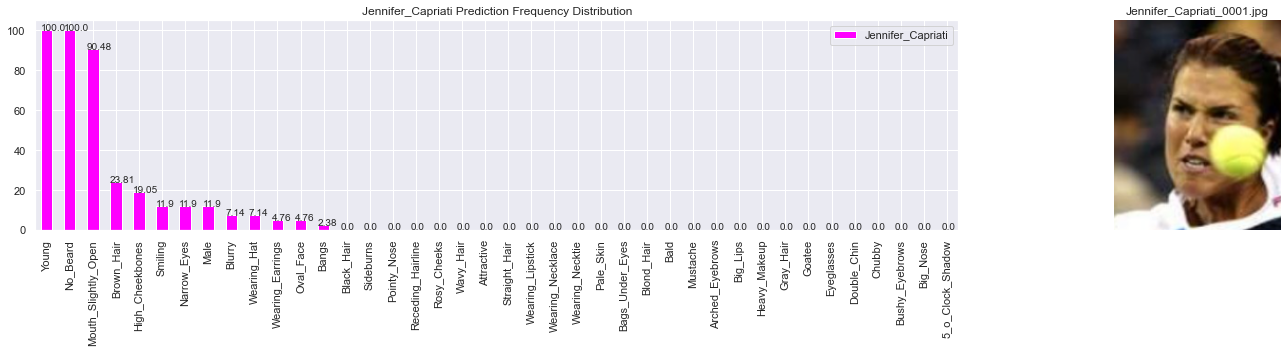

In [32]:
get_celeb_prediction(preds, name = 'Jennifer_Capriati', first_img=True) # Female, Young

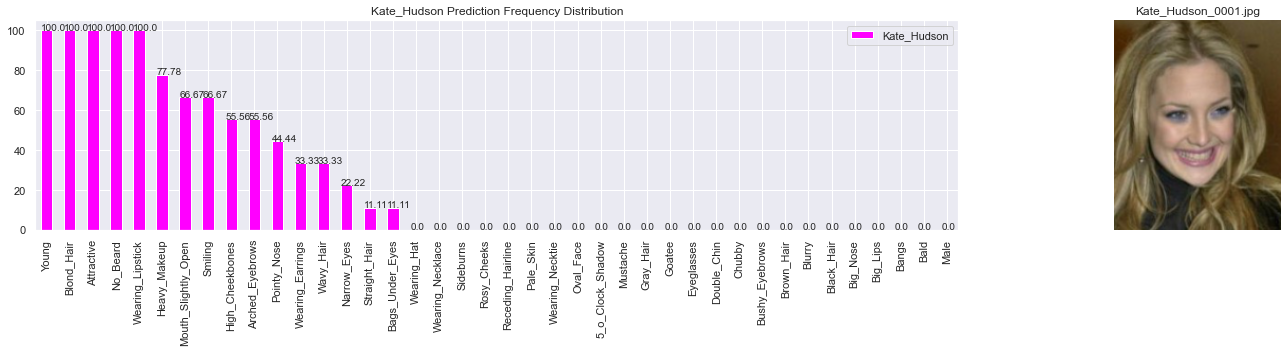

In [33]:
get_celeb_prediction(preds, name = 'Kate_Hudson', first_img=True) # Female, Blond 

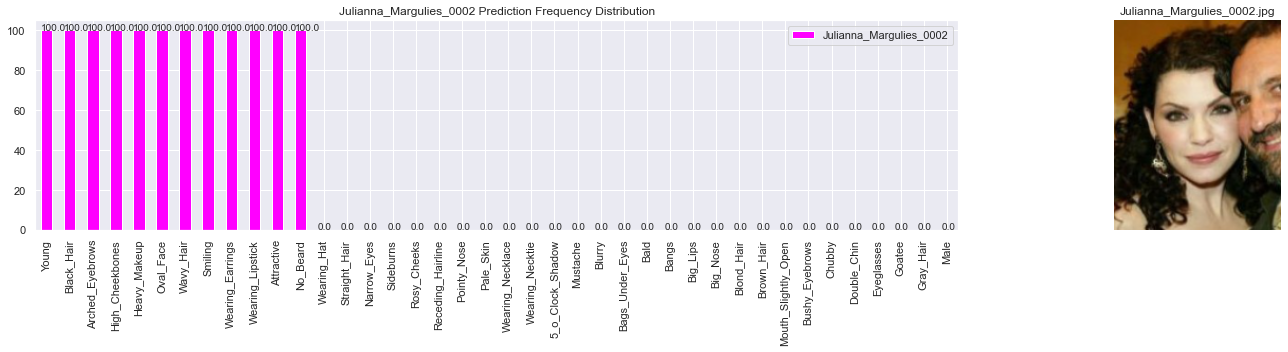

In [34]:
get_celeb_prediction(preds, name = 'Julianna_Margulies_0002', first_img=True) # Female, No_Beard, Earing, Lipstick, Makeup, Wavy, Black Hair, Arched Eyebrows

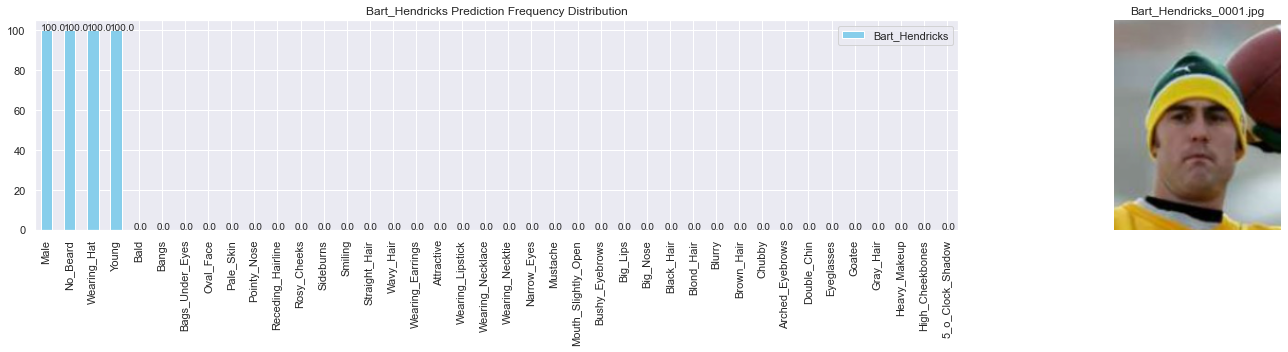

In [35]:
get_celeb_prediction(preds, name = 'Bart_Hendricks', first_img=True) # Duplicated Image Ricky_Ray_0001

=> random index: 7270


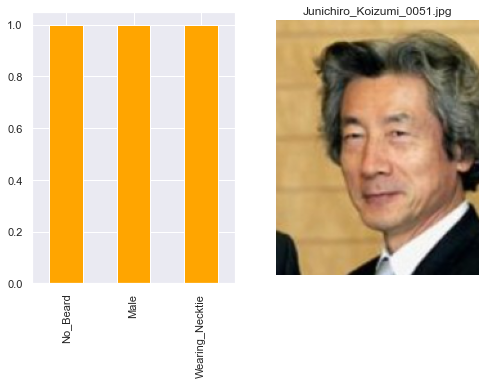

In [36]:
def plot_prediction_with_image(preds, index=None, off_neg=True):
    if index == None:
        index = np.random.randint(0, len(preds))
        print(f"=> random index: {index}")
    
    if type(index) == int:
        p_attrs = preds.iloc[index,:]
        p_img = preds.index[index]
    else:
        p_attrs = preds.loc[index, :]
        p_img = index
        index = test_dataset.imagenames.index(index)   

#     if off_neg:
#         p_attrs[p_attrs == -1] = 0
    p_attrs = p_attrs.sort_values(0, ascending=True)
    fig, (ax, ax2) = plt.subplots(ncols=2)
    my_color=np.where(p_attrs>=0, 'green', 'orange')
    if off_neg:
        p_attrs[p_attrs == 1].plot(kind='bar',ax=ax, figsize=(8, 5), color=my_color)
    else:
        p_attrs.plot(kind='barh',ax=ax, figsize=(12, 8), color=my_color)
    
    s_img = inv_normalize(test_dataset[index][0]).permute(1, 2, 0)
    ax2.imshow(s_img)
    ax2.set_axis_off()
    plt.title(p_img)
    plt.show()
    
plot_prediction_with_image(preds, None)

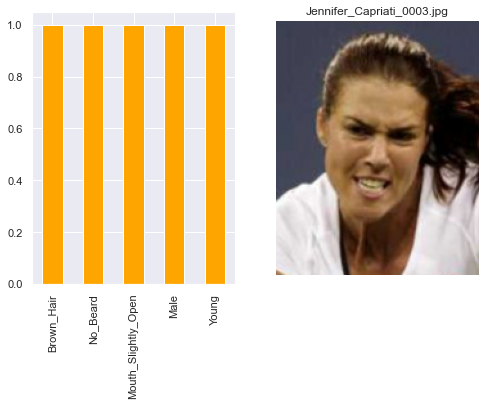

In [37]:
plot_prediction_with_image(preds, 'Jennifer_Capriati_0003.jpg') 

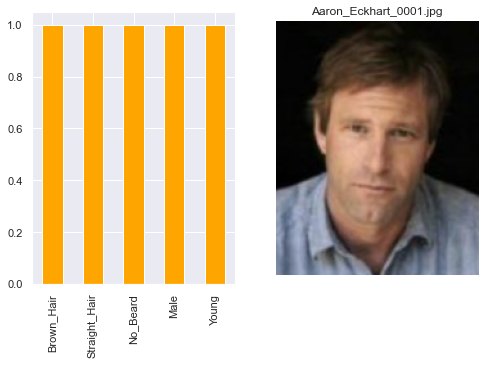

In [38]:
plot_prediction_with_image(preds, index=0)

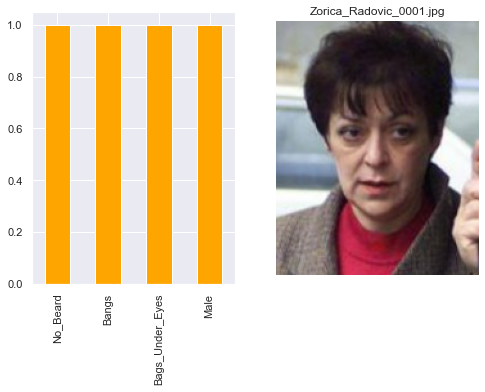

In [39]:
plot_prediction_with_image(preds, index=-5) # Hard-to-predict female

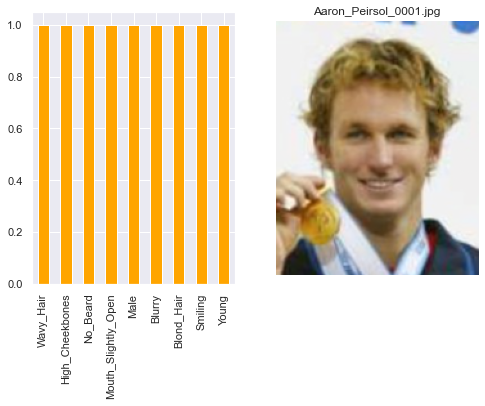

In [40]:
plot_prediction_with_image(preds, index=3) # Young, Smile, Blond, Male, Mouth open, No Beard, High Cheekbone, Wavy Hair

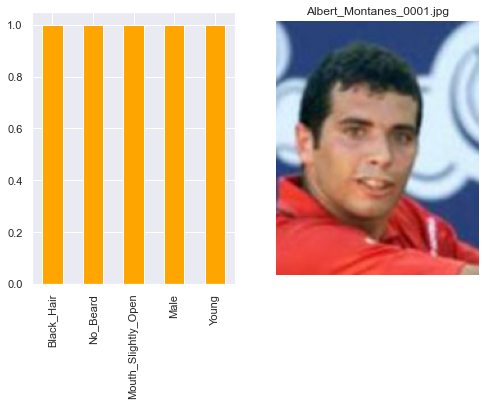

In [41]:
plot_prediction_with_image(preds, index=201) # Young, Male, Mouth open, Nobeard, Black hair

In [42]:
if ISJUPYTER:
    # Wait for notebook to save
    %autosave 1
    time.sleep(121)
    %autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [43]:
def backup_everything(run_dir, title, backup_nb=ISJUPYTER):
    if backup_nb:
        print(f"=> backing up notebook... ")
        # backup notebook html
        nb_name = title + '.ipynb'
        html_name = title + '.html'
        save_name = os.path.join(run_dir, html_name)
        !jupyter nbconvert --to html $nb_name
        shutil.move(html_name, save_name)
    
backup_everything(run_dir, title, backup_nb=ISJUPYTER)

=> backing up notebook... 


[NbConvertApp] Converting notebook ai6126-p1-inference-v0.3.ipynb to html
[NbConvertApp] Writing 3191617 bytes to ai6126-p1-inference-v0.3.html
